# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [82]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [83]:
# load in the data
azdias = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [84]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [85]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [86]:
# Let's check the difference between this 2 dataset.
set(azdias.columns)-set(customers.columns)

set()

In [87]:
set(customers.columns)-set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

- The customers table has three more fields.

In [88]:
# drop these three features
my_customers=customers.drop(labels=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis=1)

In [89]:
DIAS_attributes= pd.read_excel("DIAS Attributes - Values 2017.xlsx")

In [90]:
DIAS_attributes.shape

(2259, 5)

In [91]:
 DIAS_info=pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx")

In [92]:
# Mark nan from the azdias data
DIAS_attributes.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Attribute,Description,Value,Meaning
1,NaN,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,NaN,0,no classification possible
3,NaN,NaN,NaN,1,passive elderly
4,NaN,NaN,NaN,2,cultural elderly


In [93]:
# clean the dataset
DIAS_attributes.drop(['Unnamed: 0'],axis=1,inplace=True)

In [94]:
if 'Attribute' in DIAS_attributes.iloc[0][0]:
    DIAS_attributes.drop(index=[0],axis=0,inplace=True)

In [95]:
DIAS_attributes.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
1,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,0,no classification possible
3,NaN,NaN,1,passive elderly
4,NaN,NaN,2,cultural elderly
5,NaN,NaN,3,experience-driven elderly


In [96]:
DIAS_attributes.columns = ['Attribute','Description','Value','Meaning']

In [97]:
# fill in the attribute value.
attribute_name=''
# description_name=''
for i,v in DIAS_attributes.iterrows():
    if v['Attribute'] is np.nan:
        v['Attribute']=attribute_name
    else:
        attribute_name=v['Attribute']
#     if v['Description'] is np.nan:
#         v['Description']=description_name
#     else:
#         description_name=v['Description']

In [98]:
DIAS_attributes.head()

,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,-1,unknown
2,AGER_TYP,NaN,0,no classification possible
3,AGER_TYP,NaN,1,passive elderly
4,AGER_TYP,NaN,2,cultural elderly
5,AGER_TYP,NaN,3,experience-driven elderly


In [99]:
# find out the attribute that value contains unknown.
missing_attribute_value_list=[]
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'unknown' in v['Meaning']:
            missing_attribute_value_list.append([v['Attribute'],v['Value'],v['Meaning']])

In [100]:
# find out the attribute that the data types are numerical.
numerical_attribute=set()
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'numeric' in v['Meaning']:
            numerical_attribute.add(v['Attribute'])

In [101]:
print(numerical_attribute)

{'ANZ_TITEL', 'MIN_GEBAEUDEJAHR', 'ANZ_PERSONEN', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW'}


In [102]:
# find out the attricute that is no mention in the 2 dataset.
DIAS_attributes_name=set(DIAS_attributes['Attribute'].drop_duplicates())
DIAS_attributes_name-set(azdias.columns)

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

- None of the above attributes mentioned

In [103]:
# find out the attribute that is no description.
set(azdias.columns)-DIAS_attributes_name

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSICHERUNGEN',
 '

- Lack of description of the above attributes

In [104]:
# the 'LNR' is unique.
print(azdias['LNR'].duplicated().sum(),customers['LNR'].duplicated().sum())
print(set(azdias['LNR'])&set(customers['LNR']))

0 0
set()


In [105]:
def unknown2missing(df):
    ''' Input: dataframe
        Output: dataframe without the unknown value
        Process:
                replace the unknown value with the nan
    '''
    df_temp=df.copy()
    for l in missing_attribute_value_list:
        if l[0] in df.columns:
            if isinstance(l[1],int):
                df_temp[l[0]]=df[l[0]].replace(l[1],np.nan)
            else:
                for ll in l[1].split(','):
                    df_temp[l[0]]=df[l[0]].replace(int(ll),np.nan)
    return df_temp
        

In [ ]:
# Calculate the null value before and after replacing the unknown value in azdias dataset.
my_azdias=unknown2missing(azdias)
print(azdias.isnull().mean().mean())
print(my_azdias.isnull().mean().mean())

0.10268016415595567
0.11370020865890973


In [ ]:
# Calculate the null value before and after replacing the unknown value in customers dataset.
my_customers=unknown2missing(customers)
print(customers.isnull().mean().mean())
print(my_customers.isnull().mean().mean())

0.1960492473457283
0.20487207872308308


In [ ]:
def azdias_customers_plot(column):
    ''' Input: column
        Output: plot
        Process:
                plot the distribution of features in two dataset
    '''
    fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)
    sns.countplot(x = column, data=azdias, ax=ax1, palette="Set3")
    ax1.set_xlabel('Value')
    ax1.set_title('AZDIAS '+column+' feature')
    sns.countplot(x = column, data=customers, ax=ax2, palette="Set3")
    ax2.set_xlabel('Value')
    ax2.set_title('CUSTOMERS '+column+' feature')
    fig.tight_layout()
    plt.show()

In [ ]:
import random

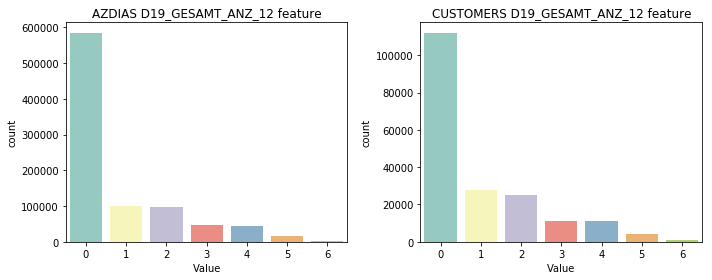

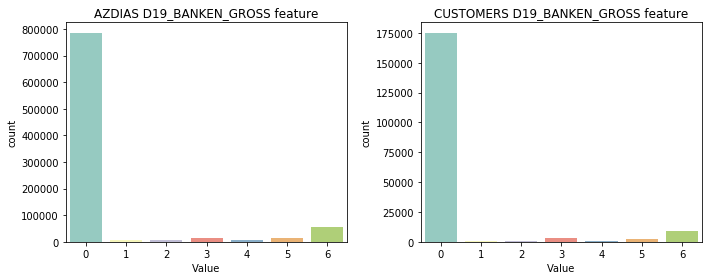

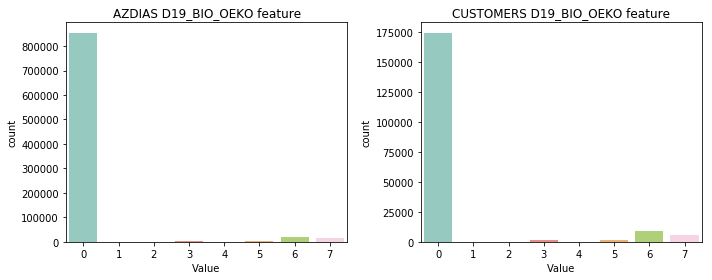

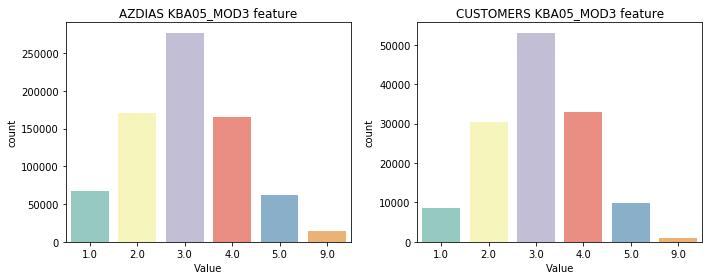

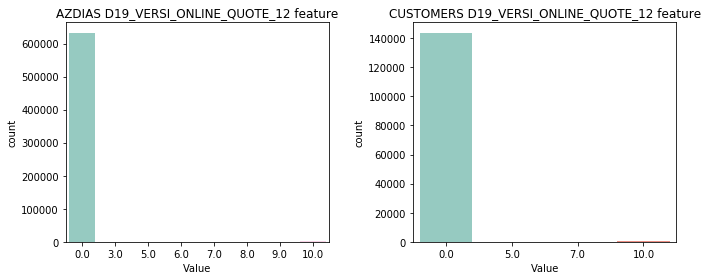

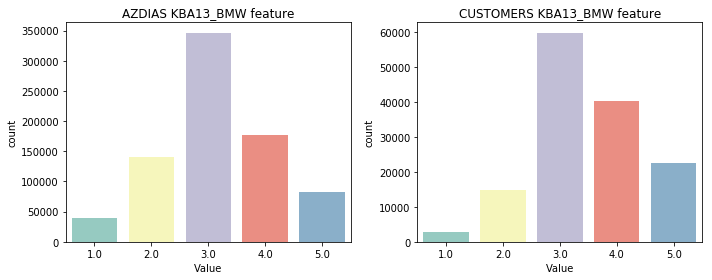

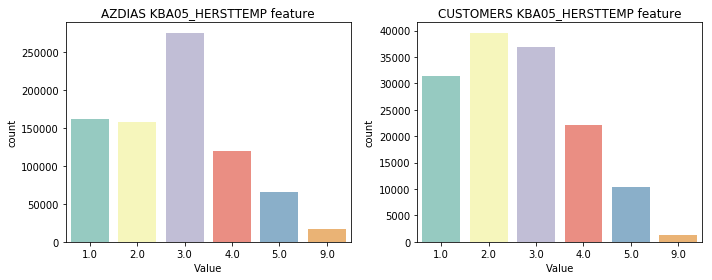

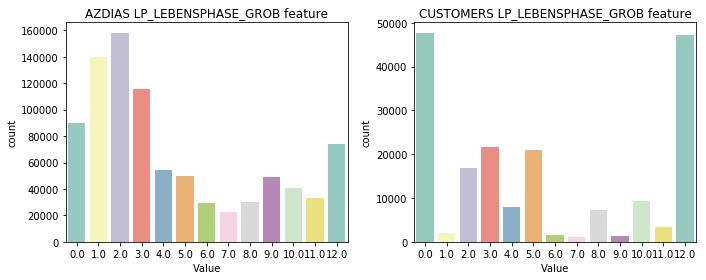

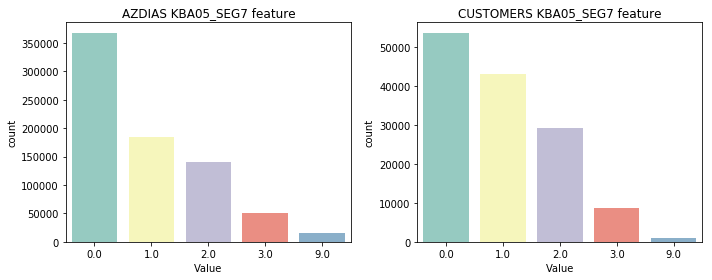

In [ ]:
for i in random.sample(range(0,len(azdias.columns)-1),10):
    azdias_customers_plot(azdias.columns[i])

- From the random distribution map, the two data sets are distributed and similar

### 1.Deal with the numerical features

In [ ]:
# define a drop features list
drop_features=set()

In [ ]:
# in numerical_attribute: 
# {'MIN_GEBAEUDEJAHR', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_TITEL', 'ANZ_PERSONEN', 'GEBURTSJAHR', 'ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW'}
my_azdias[list(numerical_attribute)].head()

- 'MIN_GEBAEUDEJAHR' will be replaced by age.
- 'GEBURTSJAHR' will be replaced by age.

In [ ]:
numerical_attribute

In [ ]:
DIAS_attributes['Attribute'].value_counts()

- I think the numeric features have only 1 values meaning.

In [ ]:
attribute_value_number=[]
for i in my_azdias.columns:
    attribute_value_number.append((len(my_azdias[i].value_counts()),i))

In [ ]:
print(sorted(attribute_value_number))

- numerical feature might have more value,so I will check the value count bigger than 30

In [ ]:
# find out the value count bigger than 30
[x for x in attribute_value_number if x[0]>30]

In [ ]:
# find more numberical attribute 
set([x[1] for x in attribute_value_number if x[0]>30])-numerical_attribute-drop_features-set(['LNR'])

- LNR will be the index,
- EINGEFUEGT_AM,D19_LETZTER_KAUF_BRANCHE,EINGEZOGENAM_HH_JAHR I don't know what is it.

In [ ]:
drop_features=drop_features|set(['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE','EINGEZOGENAM_HH_JAHR'])

In [ ]:
drop_features

In [ ]:
my_azdias['ANZ_STATISTISCHE_HAUSHALTE'].value_counts()

- It has many values so I think it's a numerical feature. 

In [ ]:
numerical_attribute.add('ANZ_STATISTISCHE_HAUSHALTE')

In [ ]:
my_azdias['EXTSEL992'].value_counts()

- It has many values so I think it's a numerical feature. 

In [ ]:
numerical_attribute.add('EXTSEL992')

In [ ]:
my_azdias['VERDICHTUNGSRAUM'].value_counts()

- It has many values so I think it's a numerical feature. 

In [ ]:
numerical_attribute.add('VERDICHTUNGSRAUM')

In [ ]:
# find out the features that have more than 30 values
set([x[1] for x in attribute_value_number if x[0]>30])-numerical_attribute-drop_features-set(['LNR'])

In [ ]:
print(my_azdias['CAMEO_DEU_2015'].value_counts(),my_azdias['CAMEO_INTL_2015'].value_counts(),my_azdias['LP_LEBENSPHASE_FEIN'].value_counts())

- It has many values so I think it's a numerical feature. 

In [ ]:
numerical_attribute.add('LP_LEBENSPHASE_FEIN')

In [ ]:
print(numerical_attribute)

- That's all,I accept the result of numerical features.

### 2.Deal with the categories features

In [ ]:
# find out the categories features
categories_attribute=set(my_azdias.columns)-numerical_attribute-drop_features-set(['LNR'])
my_azdias_categories=my_azdias[list(categories_attribute)]

In [ ]:
# See which data types are in the category properties
my_azdias_categories.columns.to_series().groupby(my_azdias_categories.dtypes).groups

In [ ]:
# focus the object data type features ['CAMEO_DEUG_2015', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
# first CAMEO_DEUG_2015,CAMEO_INTL_2015,CAMEO_DEU_2015
CAMEO_list=[]
for l in azdias.columns.tolist():
    if 'CAMEO' in l:
        CAMEO_list.append(l)
print(CAMEO_list)

In [ ]:
my_azdias_categories[CAMEO_list].head()

In [ ]:
print(my_azdias_categories['CAMEO_DEUG_2015'].value_counts())
print(my_azdias_categories['CAMEO_DEU_2015'].value_counts())
print(my_azdias_categories['CAMEO_INTL_2015'].value_counts())

In [ ]:
my_azdias_categories['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)
my_azdias_categories['CAMEO_INTL_2015'].replace('XX',np.nan,inplace=True)
my_azdias_categories['CAMEO_DEUG_2015']=my_azdias_categories['CAMEO_DEUG_2015'].astype('float')
my_azdias_categories['CAMEO_INTL_2015']=my_azdias_categories['CAMEO_INTL_2015'].astype('float')

In [ ]:
my_azdias_categories[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].corr()

- according the attribute description 'CAMEO_DEU_2015' 'CAMEO_INTL_2015' include more detail than CAMEO_DEUG_2015.The correlation between  'CAMEO_DEUG_2015'and 'CAMEO_INTL_2015' is high.

In [ ]:
# I will drop CAMEO_DEU_2015 and CAMEO_INTL_2015 
drop_features.add('CAMEO_DEU_2015')
drop_features.add('CAMEO_INTL_2015')

In [ ]:
print(drop_features)

In [ ]:
# I will check the value count is 2 as binary_attribute
binary_attribute=set([x[1] for x in attribute_value_number if x[0]==2])

In [ ]:
print(binary_attribute)

In [ ]:
multiple_categories_attribute=set(my_azdias.columns)-numerical_attribute-drop_features-set(['LNR'])-binary_attribute

In [ ]:
print(multiple_categories_attribute)

In [ ]:
my_azdias_categories[list(multiple_categories_attribute)]

In [231]:
print(binary_attribute)

{'ANREDE_KZ', 'OST_WEST_KZ', 'KBA05_SEG6', 'SOHO_KZ', 'DSL_FLAG', 'VERS_TYP', 'HH_DELTA_FLAG', 'UNGLEICHENN_FLAG', 'GREEN_AVANTGARDE', 'KONSUMZELLE'}


### 3.process the missing values and deal with some features

In [232]:
# deal with columns
azdias_col_null=(my_azdias.isnull().sum()/len(my_azdias)).sort_values(ascending=False)
customers_col_null=(my_customers.isnull().sum()/len(my_customers)).sort_values(ascending=False)

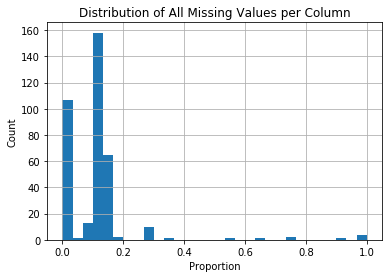

In [233]:
azdias_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

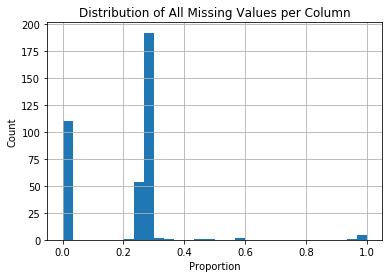

In [234]:
customers_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

In [235]:
#remove the features that has over 30% missing rate
remove_features=set(azdias_col_null[azdias_col_null>0.3].index)|set(customers_col_null[customers_col_null>0.3].index)
print(remove_features)
# azdias.drop(labels=remove_features,axis=1,inplace=True)
# customers.drop(labels=remove_features,axis=1,inplace=True)
# print(azdias.shape,customers.shape)
drop_features=drop_features|remove_features
print(drop_features)

{'TITEL_KZ', 'AGER_TYP', 'ALTER_KIND2', 'ALTER_HH', 'REGIOTYP', 'ALTER_KIND1', 'KK_KUNDENTYP', 'EXTSEL992', 'ALTER_KIND3', 'KKK', 'KBA05_BAUMAX', 'ALTER_KIND4'}
{'TITEL_KZ', 'AGER_TYP', 'ALTER_KIND2', 'EINGEFUEGT_AM', 'CAMEO_DEU_2015', 'ALTER_HH', 'REGIOTYP', 'ALTER_KIND1', 'KK_KUNDENTYP', 'EXTSEL992', 'EINGEZOGENAM_HH_JAHR', 'ALTER_KIND3', 'KKK', 'KBA05_BAUMAX', 'D19_LETZTER_KAUF_BRANCHE', 'ALTER_KIND4', 'CAMEO_INTL_2015'}


In [236]:
# redefine the categories_attribute and the numerical_attribute
categories_attribute=categories_attribute-drop_features
numerical_attribute=numerical_attribute-drop_features
binary_attribute=binary_attribute-drop_features

In [237]:
drop_features

{'AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KKK',
 'KK_KUNDENTYP',
 'REGIOTYP',
 'TITEL_KZ'}

In [238]:
my_azdias.drop(labels=drop_features,axis=1,inplace=True)
my_customers.drop(labels=drop_features,axis=1,inplace=True)

In [239]:
# deal with rows
azdias_row_null=(my_azdias.isnull().mean(axis=1)).sort_values(ascending=False)
customers_row_null=(my_customers.isnull().mean(axis=1)).sort_values(ascending=False)

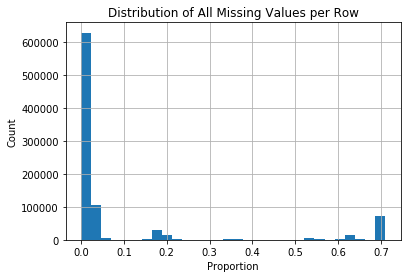

In [240]:
azdias_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

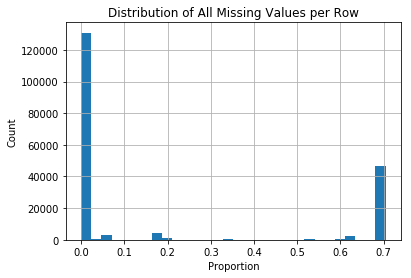

In [241]:
customers_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

In [242]:
print(my_azdias.shape,my_customers.shape)

(891221, 349) (191652, 352)


In [243]:
#remove the row that has over 10% missing rate
azdias_remove_row=azdias_row_null[azdias_row_null>0.1].index
customers_remove_row=customers_row_null[customers_row_null>0.1].index

my_azdias.drop(index=azdias_remove_row,axis=0,inplace=True)
my_customers.drop(index=customers_remove_row,axis=0,inplace=True)

In [244]:
print(my_azdias.shape,my_customers.shape)

(737215, 349) (134245, 352)


In [245]:
print(my_azdias.isnull().mean().mean())
print(my_customers.isnull().mean().mean())

0.007324992784837431
0.002320109264269196


In [246]:
# set index
my_azdias.set_index('LNR',inplace=True)
my_customers.set_index('LNR',inplace=True)

In [247]:
# dorp 3 attribute that only in my_customers dataset  

my_customers.drop(labels=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis=1,inplace=True)

In [248]:
# deal with the 'MIN_GEBAEUDEJAHR' , 'GEBURTSJAHR'
my_azdias['MIN_GEBAEUDEJAHR']=2018-my_azdias['MIN_GEBAEUDEJAHR']
my_azdias['GEBURTSJAHR']=2018-my_azdias['GEBURTSJAHR']

my_customers['MIN_GEBAEUDEJAHR']=2018-my_customers['MIN_GEBAEUDEJAHR']
my_customers['GEBURTSJAHR']=2018-my_customers['GEBURTSJAHR']

In [249]:
# fill the missing data in numerical_attribute
for l in numerical_attribute:
    my_azdias[l]=my_azdias[l].fillna(value=round(my_azdias[l].mean()))
    my_customers[l]=my_customers[l].fillna(value=round(my_customers[l].mean()))

In [250]:
len(my_azdias[list(numerical_attribute)].isnull().any()[my_azdias[list(numerical_attribute)].isnull().any()==True].index)

0

In [251]:
len(my_customers[list(numerical_attribute)].isnull().any()[my_customers[list(numerical_attribute)].isnull().any()==True].index)

0

In [252]:
my_azdias['CAMEO_DEUG_2015'].value_counts()

8      74748
6      58195
9      57468
4      55289
8.0    54098
2      44417
3      44186
6.0    42485
9.0    41971
7      41853
4.0    40291
2.0    32189
3.0    32128
7.0    30620
5      28975
5.0    20733
1      19836
1.0    14394
X        284
Name: CAMEO_DEUG_2015, dtype: int64

In [253]:
# deal with the 'CAMEO_DEUG_2015',replace the X value by np.nan
my_azdias['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)
my_customers['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

In [254]:
my_azdias['CAMEO_DEUG_2015']=my_azdias['CAMEO_DEUG_2015'].astype('float')
my_customers['CAMEO_DEUG_2015']=my_customers['CAMEO_DEUG_2015'].astype('float')

In [255]:
attribute_value_number=[]
for i in categories_attribute:
    attribute_value_number.append((len(my_azdias[i].value_counts()),i))
print(sorted(attribute_value_number))

[(3, 'HEALTH_TYP'), (3, 'KBA05_ANTG4'), (3, 'KBA05_KRSKLEIN'), (3, 'KBA05_KRSOBER'), (3, 'KBA05_KRSVAN'), (3, 'KBA05_KRSZUL'), (3, 'KBA05_MAXVORB'), (3, 'KBA13_ANTG4'), (3, 'KBA13_KMH_110'), (3, 'KBA13_KMH_251'), (3, 'KBA13_KW_30'), (3, 'NATIONALITAET_KZ'), (3, 'PLZ8_ANTG4'), (3, 'STRUKTURTYP'), (4, 'D19_TELKO_ONLINE_QUOTE_12'), (4, 'KBA05_ANHANG'), (4, 'KBA05_ANTG3'), (4, 'KBA05_MAXBJ'), (4, 'KBA05_MAXSEG'), (4, 'KBA05_MOD8'), (4, 'KBA05_MOTOR'), (4, 'KBA05_MOTRAD'), (4, 'KBA05_SEG1'), (4, 'KBA05_SEG7'), (4, 'KBA05_SEG8'), (4, 'KBA05_SEG9'), (4, 'KBA13_ANTG3'), (4, 'KBA13_KRSSEG_KLEIN'), (4, 'KBA13_KRSSEG_OBER'), (4, 'KBA13_KRSSEG_VAN'), (4, 'KBA13_KRSZUL_NEU'), (4, 'KBA13_MOTOR'), (4, 'PLZ8_ANTG3'), (4, 'SHOPPER_TYP'), (5, 'ALTERSKATEGORIE_GROB'), (5, 'CJT_KATALOGNUTZER'), (5, 'CJT_TYP_1'), (5, 'CJT_TYP_2'), (5, 'CJT_TYP_3'), (5, 'CJT_TYP_4'), (5, 'CJT_TYP_5'), (5, 'CJT_TYP_6'), (5, 'FINANZ_ANLEGER'), (5, 'FINANZ_HAUSBAUER'), (5, 'FINANZ_MINIMALIST'), (5, 'FINANZ_SPARER'), (5, 'FINAN

In [381]:
pd.set_option('display.max_columns', None)
my_azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEIN

In [261]:
my_azdias[list(binary_attribute)]=my_azdias[list(binary_attribute)].astype('object')
my_customers[list(binary_attribute)]=my_customers[list(binary_attribute)].astype('object')

In [262]:
%%time
my_azdias[list(categories_attribute)]=my_azdias[list(categories_attribute)].astype('float')
my_customers[list(categories_attribute)]=my_customers[list(categories_attribute)].astype('float')

Wall time: 16.5 s


In [93]:
# To reduce the memory use of PCA, I choose almost categories to ordinal with DIAS_Attributes

In [263]:
%%time
my_azdias_dummy=pd.get_dummies(data=my_azdias[list(binary_attribute)])
my_customers_dummy=pd.get_dummies(data=my_customers[list(binary_attribute)])

Wall time: 3.13 s


In [264]:
print(my_azdias_dummy.shape)

(737215, 20)


In [265]:
print(my_customers_dummy.shape)

(134245, 20)


In [266]:
my_azdias_df = pd.concat([my_azdias, my_azdias_dummy], axis=1)
my_customers_df = pd.concat([my_customers, my_customers_dummy], axis=1 )

In [267]:
my_azdias_df.drop(labels=binary_attribute,axis=1,inplace=True)
my_customers_df.drop(labels=binary_attribute,axis=1,inplace=True)

In [268]:
%%time
my_azdias_df.to_pickle("my_azdias_df.pkl")
my_customers_df.to_pickle("my_customers_df.pkl")

Wall time: 8.5 s


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [269]:
%%time
if  'my_azdias_df' in locals() and 'my_customers_df' in locals():
    pass
else:
    my_azdias_df=pd.read_pickle("my_azdias_df.pkl")
    my_customers_df=pd.read_pickle("my_customers_df.pkl")

Wall time: 0 ns


In [270]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

In [271]:
my_azdias_df.fillna(0,inplace=True)
my_customers_df.fillna(0,inplace=True)

- Use my_azdias_df with PCA

In [273]:
%%time
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(my_azdias_df) 
scaled_df=pd.DataFrame(scaled, columns=my_azdias_df.columns)

Wall time: 8.28 s


In [291]:
def scaler_df(df):
    scaler = preprocessing.StandardScaler()
    scaled = scaler.fit_transform(df) 
    return pd.DataFrame(scaled, columns=df.columns)

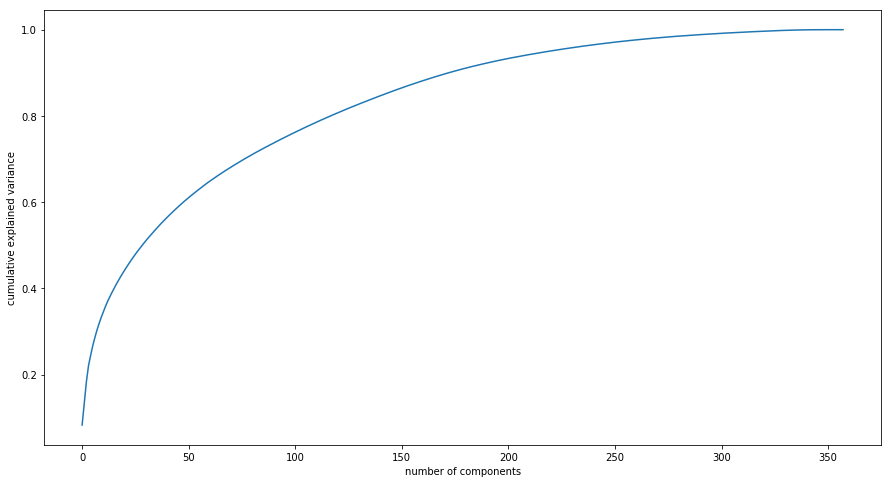

Wall time: 41 s


In [274]:
%%time
plt.figure(figsize=(15,8)) 
pca = PCA().fit(scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

<BarContainer object of 358 artists>

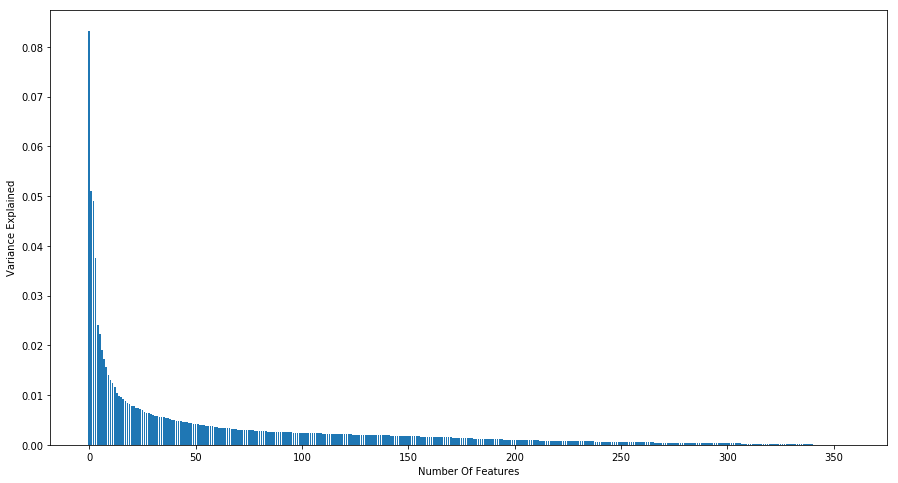

In [275]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(15,8)) 
explained_variance_ratio=[val for val in pca.explained_variance_ratio_]
cv=np.cumsum(np.round(explained_variance_ratio, decimals=3))
plt.ylabel('Variance Explained')
plt.xlabel('Number Of Features')
plt.bar(range(0,len(explained_variance_ratio)),explained_variance_ratio)

- I have done dimensionality reduction by getting explained ratio of principal components, As i observed 120 components/ eigen values were sufficient to explain more 80% variance in data so I opted that out. 

In [276]:
pca = PCA(n_components=120)
principalComponents_updated = pca.fit_transform(scaled)

In [277]:
first_comp=pca.components_[0]
first_comp_sorted=sorted(first_comp,reverse=True)
first_comp_index=sorted(range(len(first_comp)), key=lambda k: first_comp[k])

In [278]:
cols_sorted=scaled_df.columns[first_comp_index]
positive_index=first_comp_index[:10]
negative_index=first_comp_index[-10:]
positive_cols=cols_sorted[:10]
negative_cols=cols_sorted[-10:]
positive_weights=first_comp_sorted[:10]
negative_weights=first_comp_sorted[-10:]
for i in range(10):
    print('Positive: ',positive_index[i],positive_cols[i],positive_weights[i],' Negative: ',negative_index[i],negative_cols[i],negative_weights[i])

Positive:  298 PLZ8_ANTG3 0.13741664572710197  Negative:  176 KBA13_AUTOQUOTE -0.10331910395194509
Positive:  172 KBA13_ANTG3 0.1298190240084241  Negative:  119 KBA05_GBZ -0.10487181261805845
Positive:  173 KBA13_ANTG4 0.1285754337346762  Negative:  112 KBA05_AUTOQUOT -0.12032497252550593
Positive:  177 KBA13_BAUMAX 0.12738733550631262  Negative:  291 MOBI_RASTER -0.12260744726574807
Positive:  299 PLZ8_ANTG4 0.1273278257929745  Negative:  289 LP_STATUS_GROB -0.12340480657607729
Positive:  101 HH_EINKOMMEN_SCORE 0.12451487334333232  Negative:  288 LP_STATUS_FEIN -0.12385832026400907
Positive:  300 PLZ8_BAUMAX 0.12445579135166449  Negative:  108 KBA05_ANTG1 -0.12447550670301913
Positive:  10 CAMEO_DEUG_2015 0.1238219641151349  Negative:  296 PLZ8_ANTG1 -0.12492542478780111
Positive:  86 EWDICHTE 0.12054055500573795  Negative:  170 KBA13_ANTG1 -0.12842065539609357
Positive:  295 ORTSGR_KLS9 0.11724401855608445  Negative:  292 MOBI_REGIO -0.1286790359771247


In [279]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weightsOfPca(componentIndex):
    components=pca.components_[componentIndex]
    componentspd=pd.DataFrame(components,columns=['weight'])
    componentspd['name']=list(my_azdias_df.columns)
    print(componentspd.sort_values(by='weight',ascending=False))

In [280]:
weightsOfPca(0)

       weight                        name
292  0.137417                  MOBI_REGIO
170  0.129819                 KBA13_ANTG1
296  0.128575                  PLZ8_ANTG1
108  0.127387                 KBA05_ANTG1
288  0.127328              LP_STATUS_FEIN
289  0.124515              LP_STATUS_GROB
291  0.124456                 MOBI_RASTER
112  0.123822              KBA05_AUTOQUOT
119  0.120541                   KBA05_GBZ
176  0.117244             KBA13_AUTOQUOTE
286  0.107256         LP_LEBENSPHASE_FEIN
89   0.104917           FINANZ_MINIMALIST
287  0.100000         LP_LEBENSPHASE_GROB
98   0.098210                 GEMEINDETYP
40   0.096984           D19_GESAMT_ANZ_24
202  0.096824                   KBA13_GBZ
107  0.095935                KBA05_ANHANG
301  0.093594                    PLZ8_GBZ
283  0.092750                 KONSUMNAEHE
168  0.091985        KBA13_ALTERHALTER_60
39   0.090384           D19_GESAMT_ANZ_12
71   0.090165          D19_VERSAND_ANZ_24
294  0.089120           ONLINE_AFF

In [281]:
weightsOfPca(1)

       weight                         name
273  0.122081                KBA13_SITZE_5
260  0.107916         KBA13_SEG_KLEINWAGEN
224  0.104148            KBA13_KMH_140_210
40   0.103088            D19_GESAMT_ANZ_24
204  0.102872              KBA13_HALTER_25
340  0.102656                OST_WEST_KZ_O
261  0.101243      KBA13_SEG_KOMPAKTKLASSE
225  0.100032                KBA13_KMH_180
294  0.099271            ONLINE_AFFINITAET
87   0.098607               FINANZ_ANLEGER
39   0.097744            D19_GESAMT_ANZ_12
238  0.093541                KBA13_KW_0_60
71   0.092631           D19_VERSAND_ANZ_24
214  0.091400            KBA13_HERST_ASIEN
166  0.091258         KBA13_ALTERHALTER_30
44   0.087370   D19_GESAMT_ONLINE_QUOTE_12
70   0.085891           D19_VERSAND_ANZ_12
75   0.084892  D19_VERSAND_ONLINE_QUOTE_12
259  0.084248            KBA13_SEG_KLEINST
303  0.082714        PRAEGENDE_JUGENDJAHRE
198  0.082206              KBA13_FAB_ASIEN
90   0.076611                FINANZ_SPARER
218  0.0755

In [282]:
def pca_analysis(ind):
    first_comp=pca.components_[ind]
    first_comp_sorted=sorted(first_comp,reverse=True)
    first_comp_index=sorted(range(len(first_comp)), key=lambda k: first_comp[k])
    cols_sorted=scaled_df.columns[first_comp_index]
    positive_index=first_comp_index[:10]
    negative_index=first_comp_index[-10:]
    positive_cols=cols_sorted[:10]
    negative_cols=cols_sorted[-10:]
    positive_weights=first_comp_sorted[:10]
    negative_weights=first_comp_sorted[-10:]
    for i in range(10):
        print('Positive: ',positive_index[i],positive_cols[i],positive_weights[i],' Negative: ',negative_index[i],negative_cols[i],negative_weights[i])

In [283]:
pca_analysis(1)

Positive:  216 KBA13_HERST_BMW_BENZ 0.12208103256740503  Negative:  87 FINANZ_ANLEGER -0.10259370673783343
Positive:  251 KBA13_MERCEDES 0.10791558352412044  Negative:  294 ONLINE_AFFINITAET -0.10265580819409346
Positive:  265 KBA13_SEG_OBEREMITTELKLASSE 0.10414801794172882  Negative:  225 KBA13_KMH_180 -0.1043176089372578
Positive:  184 KBA13_BMW 0.10308830028090588  Negative:  261 KBA13_SEG_KOMPAKTKLASSE -0.10706455641343558
Positive:  272 KBA13_SITZE_4 0.10287163483890333  Negative:  340 OST_WEST_KZ_O -0.1118012708884926
Positive:  268 KBA13_SEG_SPORTWAGEN 0.10265580819409346  Negative:  204 KBA13_HALTER_25 -0.11374984492404729
Positive:  120 KBA05_HERST1 0.10124316421141619  Negative:  40 D19_GESAMT_ANZ_24 -0.11771630222386512
Positive:  227 KBA13_KMH_211 0.1000316412771328  Negative:  224 KBA13_KMH_140_210 -0.12243923509496826
Positive:  341 OST_WEST_KZ_W 0.09927144682304474  Negative:  260 KBA13_SEG_KLEINWAGEN -0.12727471602058865
Positive:  228 KBA13_KMH_250 0.09860703409475978 

In [284]:
pca_analysis(2)

Positive:  15 CJT_TYP_3 0.12921322936691948  Negative:  71 D19_VERSAND_ANZ_24 -0.1019226193229541
Positive:  17 CJT_TYP_5 0.12747645888861753  Negative:  39 D19_GESAMT_ANZ_12 -0.10217853127595235
Positive:  18 CJT_TYP_6 0.12010832102312383  Negative:  91 FINANZ_UNAUFFAELLIGER -0.10464584583498651
Positive:  43 D19_GESAMT_ONLINE_DATUM 0.11664196414822646  Negative:  90 FINANZ_SPARER -0.10606570697107273
Positive:  74 D19_VERSAND_ONLINE_DATUM 0.1166391531920004  Negative:  40 D19_GESAMT_ANZ_24 -0.10847960760523823
Positive:  16 CJT_TYP_4 0.11447322488453797  Negative:  13 CJT_TYP_1 -0.10876466644190823
Positive:  41 D19_GESAMT_DATUM 0.11022611365870721  Negative:  216 KBA13_HERST_BMW_BENZ -0.11283755915791174
Positive:  72 D19_VERSAND_DATUM 0.10901502652646117  Negative:  303 PRAEGENDE_JUGENDJAHRE -0.11318120224873314
Positive:  12 CJT_KATALOGNUTZER 0.10800258514134262  Negative:  14 CJT_TYP_2 -0.11449586643762687
Positive:  337 ALTERSKATEGORIE_GROB 0.10609871812344113  Negative:  294 ON

In [285]:
%%time
kmeans_avg=[]
kmeans_res_li=[]
# Over a number of different cluster counts...
for ind in range(2,30):
    # run k-means clustering on the data and...
    print('For Cluster',ind,'Processing is going on')
    kmeans=KMeans(n_clusters=ind, random_state=0)
    res_kmeans=kmeans.fit_predict(principalComponents_updated)
    kmeans_res_li.append(res_kmeans)
    # compute the average within-cluster distances.
    kmeans_avg.append((kmeans.score(principalComponents_updated)/len(principalComponents_updated))*-1)

For Cluster 2 Processing is going on
For Cluster 3 Processing is going on
For Cluster 4 Processing is going on
For Cluster 5 Processing is going on
For Cluster 6 Processing is going on
For Cluster 7 Processing is going on
For Cluster 8 Processing is going on
For Cluster 9 Processing is going on
For Cluster 10 Processing is going on
For Cluster 11 Processing is going on
For Cluster 12 Processing is going on
For Cluster 13 Processing is going on
For Cluster 14 Processing is going on
For Cluster 15 Processing is going on
For Cluster 16 Processing is going on
For Cluster 17 Processing is going on
For Cluster 18 Processing is going on
For Cluster 19 Processing is going on
For Cluster 20 Processing is going on
For Cluster 21 Processing is going on
For Cluster 22 Processing is going on
For Cluster 23 Processing is going on
For Cluster 24 Processing is going on
For Cluster 25 Processing is going on
For Cluster 26 Processing is going on
For Cluster 27 Processing is going on
For Cluster 28 Proce

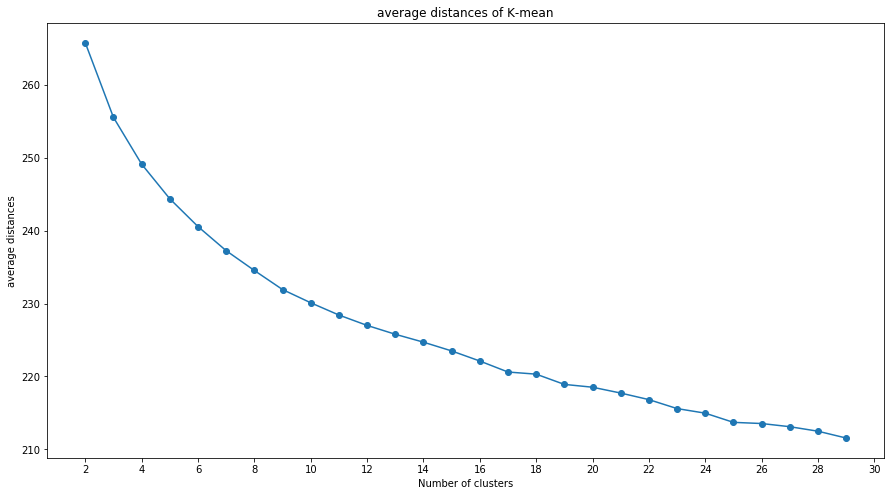

In [287]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(15,8)) 
plt.title('average distances of K-mean')
plt.xlabel('Number of clusters')
plt.ylabel('average distances')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28],[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30])
plt.plot(kmeans_avg,marker='o')

In [288]:
print(kmeans_avg)

[265.78693795142846, 255.54609878664337, 249.1282582871704, 244.37029492858758, 240.5601349737071, 237.24954747568063, 234.53308971493055, 231.91725923020277, 230.1020745412355, 228.4204189152548, 226.99572496296784, 225.78122011526165, 224.6955249718247, 223.49546868680014, 222.10913901372146, 220.59934164861957, 220.30624811678518, 218.9000553310432, 218.51430714477706, 217.71238117959248, 216.81298137098966, 215.58277648601333, 214.95254721235187, 213.69229033653772, 213.53193787076756, 213.09609920409144, 212.47792770200752, 211.54145946843963]


- I think 17 is the best.

In [289]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans=KMeans(n_clusters=17, random_state=0)
AZDIAS_kmeans_17=kmeans.fit_predict(principalComponents_updated)

In [290]:
print(AZDIAS_kmeans_17)

[ 1 14  3 ... 14  1  2]


In [300]:
# Do it for CUSTOMERS
CUSTOMERS_scaler=scaler_df(my_customers_df)
principalComponents_CUSTOMERS = pca.fit_transform(CUSTOMERS_scaler)
CUSTOMERS_kmeans_17=kmeans.predict(principalComponents_CUSTOMERS)

In [301]:
print(CUSTOMERS_kmeans_17)

[15  8  7 ...  6 12  9]


In [304]:
AZDIAS_list=np.bincount(AZDIAS_kmeans_17)
print(AZDIAS_list)
CUSTOMERS_list=np.bincount(CUSTOMERS_kmeans_17)
print(CUSTOMERS_list)

[49678 54012 65316 58419 42873 51516 37575 42731 56092 49233 34503 61199
   706  1498 60327 27824 43713]
[ 3641  6778  2758 12490  7728 10828 12086 12191 10902 10754  3175  8095
  7434  2650  4373 13967  4395]


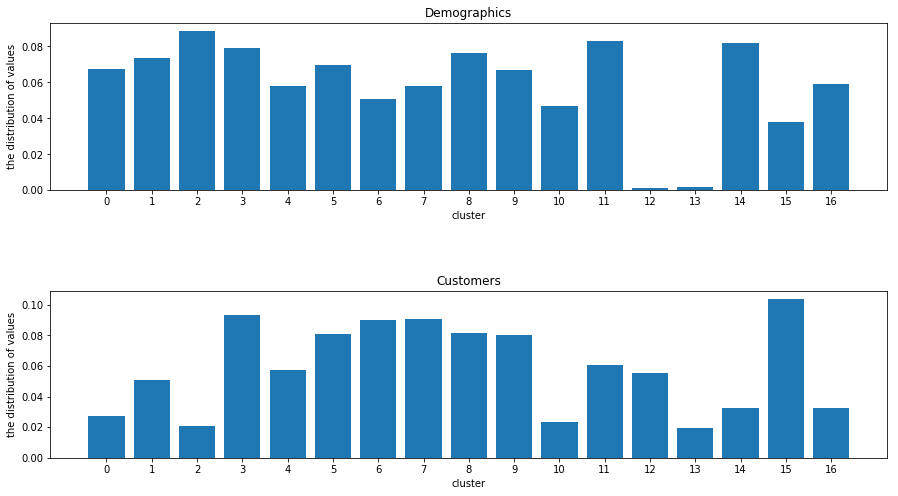

In [318]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


percent_bin_list = list(map(lambda i: i/len(AZDIAS_kmeans_17), AZDIAS_list)) 
customers_percent_bin_list = list(map(lambda i: i/len(CUSTOMERS_kmeans_17), CUSTOMERS_list)) 
plt.figure(figsize=(15,8)) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.6)

ax1=plt.subplot(211)
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],percent_bin_list)
ax1.set_title('Demographics')
ax1.set_xlabel('cluster')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
ax1.set_ylabel('the distribution of values')

ax2=plt.subplot(212)
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],customers_percent_bin_list)
ax2.set_title('Customers')
ax2.set_xlabel('cluster')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
ax2.set_ylabel('the distribution of values')
plt.show()

In [319]:
overrepresented=kmeans.cluster_centers_[8]
print(overrepresented)

[ 6.42683308e+00 -3.30155582e+00 -1.43480498e+00  4.38156699e-02
  3.12733024e-01 -9.62049096e-01 -3.45042828e-01  9.25786503e-01
  8.79831966e-01 -1.77679668e-01 -6.55321648e-01  8.90431335e-02
 -2.95205592e-02  1.80692619e-01 -5.89831518e-01 -4.88899768e-01
  9.52345882e-02 -1.98003530e-01 -2.84024654e-01  6.87243412e-01
 -1.93351866e-01 -1.44223186e-01  1.61814572e-01 -2.55260701e-01
  5.36138405e-02  2.32687635e-01 -5.06165049e-01 -1.82305935e-01
 -2.08983984e-01  4.59989825e-01  1.10012147e-01 -1.46975833e-01
 -2.46193106e-02 -4.46759743e-03  1.10075857e-01  2.30286013e-02
  8.45047148e-03 -4.77593098e-03  1.08720205e-01 -9.31314486e-02
 -4.37189882e-02 -3.40007914e-02  1.38301980e-01  5.35878357e-02
 -5.46475936e-02 -1.38696029e-01 -6.16750181e-02 -1.55234515e-01
 -5.45501451e-02  1.65420975e-02 -6.85713038e-02  1.28893081e-02
 -3.41388923e-02  1.07927087e-02  8.87050016e-02 -7.44169016e-02
  1.27879865e-01 -5.60671024e-02  8.22962711e-02 -1.15181564e-01
  3.37259343e-02  5.07670

In [320]:
# check the details
overrepresentedpd=pd.DataFrame(overrepresented,columns=['weight'])
# overrepresentedpd['rank']=overrepresentedpd.index
print(overrepresentedpd.sort_values(by='weight',ascending=False))

       weight
0    6.426833
7    0.925787
8    0.879832
19   0.687243
29   0.459990
4    0.312733
25   0.232688
13   0.180693
22   0.161815
42   0.138302
56   0.127880
80   0.126809
112  0.119738
34   0.110076
30   0.110012
38   0.108720
118  0.107490
116  0.099716
16   0.095235
77   0.091809
11   0.089043
54   0.088705
82   0.088245
58   0.082296
70   0.080122
115  0.079190
65   0.074347
97   0.057206
24   0.053614
43   0.053588
..        ...
90  -0.066200
96  -0.067083
50  -0.068571
88  -0.068772
55  -0.074417
39  -0.093131
59  -0.115182
66  -0.128865
45  -0.138696
21  -0.144223
31  -0.146976
63  -0.152758
47  -0.155235
75  -0.156755
9   -0.177680
27  -0.182306
20  -0.193352
17  -0.198004
71  -0.205041
28  -0.208984
23  -0.255261
18  -0.284025
6   -0.345043
15  -0.488900
26  -0.506165
14  -0.589832
10  -0.655322
5   -0.962049
2   -1.434805
1   -3.301556

[120 rows x 1 columns]


In [322]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented=kmeans.cluster_centers_[14]
print(underrepresented)

[ 7.96495733e+00 -3.48328732e+00  6.85052780e+00  2.87460166e+00
 -2.25139560e+00  9.45252779e-01  3.95171683e-01 -1.62835630e-01
 -2.97376325e-02 -4.85804683e-01  1.11461276e+00 -4.59866849e-02
  2.14482881e-01 -3.36351329e-01 -8.20699252e-02 -1.70286454e-01
  4.91119479e-02 -1.68278023e-01  1.81961100e-01 -1.02095241e-01
  8.49806368e-02  7.61043651e-02  1.92873613e-03  4.96248272e-01
  8.98007489e-02 -5.70641540e-01  4.04585382e-01 -6.63398066e-02
  1.93484996e-02 -2.08665360e-01  6.10234323e-02 -1.72777496e-02
 -3.34510255e-01  2.96791129e-01 -4.69982140e-02  9.87909672e-02
 -4.50765361e-02 -1.00238226e-01 -1.61958457e-01  9.87755205e-02
 -2.83740056e-02  6.45191710e-02  1.00055514e-01  4.19931734e-02
  8.76730466e-02 -2.77294515e-02 -4.31299577e-02 -5.94857478e-02
  6.20443859e-02 -3.45470092e-02 -8.52926436e-02 -2.15131951e-01
  4.08579591e-01  2.22428333e-01 -8.50844397e-02 -8.40531734e-02
  8.35059322e-02  8.32769871e-02 -2.03879364e-01  2.34395202e-02
 -2.81831632e-01 -1.93164

In [323]:
# check the details
underrepresentedpd=pd.DataFrame(underrepresented,columns=['weight'])
# overrepresentedpd['rank']=overrepresentedpd.index
print(underrepresentedpd.sort_values(by='weight',ascending=False))

       weight
0    7.964957
2    6.850528
3    2.874602
10   1.114613
5    0.945253
23   0.496248
52   0.408580
26   0.404585
6    0.395172
33   0.296791
66   0.292768
53   0.222428
12   0.214483
74   0.205588
18   0.181961
71   0.180106
75   0.173906
85   0.130151
62   0.127159
63   0.121297
81   0.118500
83   0.111277
42   0.100056
35   0.098791
39   0.098776
90   0.095750
93   0.091026
24   0.089801
44   0.087673
20   0.084981
..        ...
19  -0.102095
101 -0.111899
86  -0.113984
67  -0.114212
78  -0.114639
105 -0.117169
112 -0.118615
80  -0.132797
64  -0.132954
82  -0.138592
72  -0.142298
79  -0.145277
118 -0.157869
38  -0.161958
7   -0.162836
17  -0.168278
15  -0.170286
61  -0.193165
58  -0.203879
29  -0.208665
51  -0.215132
70  -0.258990
60  -0.281832
68  -0.307121
32  -0.334510
13  -0.336351
9   -0.485805
25  -0.570642
4   -2.251396
1   -3.483287

[120 rows x 1 columns]


In [321]:
weightsOfPca(0)

       weight                        name
172  0.141973                 KBA13_ANTG3
298  0.140245                  PLZ8_ANTG3
177  0.135103                KBA13_BAUMAX
173  0.133349                 KBA13_ANTG4
300  0.131754                 PLZ8_BAUMAX
86   0.131194                    EWDICHTE
299  0.130332                  PLZ8_ANTG4
88   0.128977            FINANZ_HAUSBAUER
295  0.124535                 ORTSGR_KLS9
297  0.107997                  PLZ8_ANTG2
10   0.101741             CAMEO_DEUG_2015
101  0.101719          HH_EINKOMMEN_SCORE
111  0.093613                 KBA05_ANTG4
324  0.091907                 STRUKTURTYP
171  0.090659                 KBA13_ANTG2
304  0.090432                    RELAT_AB
110  0.090011                 KBA05_ANTG3
330  0.088765                    VK_DHT4A
8    0.087952                      ARBEIT
357  0.086555             KONSUMZELLE_1.0
41   0.084661            D19_GESAMT_DATUM
72   0.083292           D19_VERSAND_DATUM
43   0.082052     D19_GESAMT_ONLIN

In [324]:
weightsOfPca(2)

       weight                         name
40   0.170640            D19_GESAMT_ANZ_24
39   0.161736            D19_GESAMT_ANZ_12
71   0.159669           D19_VERSAND_ANZ_24
70   0.149544           D19_VERSAND_ANZ_12
294  0.142420            ONLINE_AFFINITAET
303  0.141528        PRAEGENDE_JUGENDJAHRE
75   0.137315  D19_VERSAND_ONLINE_QUOTE_12
44   0.136621   D19_GESAMT_ONLINE_QUOTE_12
14   0.134251                    CJT_TYP_2
90   0.127910                FINANZ_SPARER
13   0.124691                    CJT_TYP_1
1    0.116144         ALTERSKATEGORIE_FEIN
5    0.090756                 ANZ_PERSONEN
87   0.090733               FINANZ_ANLEGER
20   0.089181            D19_BANKEN_ANZ_24
76   0.089079             D19_VERSAND_REST
11   0.088681                CJT_GESAMTTYP
22   0.085323            D19_BANKEN_DIREKT
284  0.083138              LP_FAMILIE_FEIN
37   0.083055                 D19_FREIZEIT
317  0.081771                SEMIO_PFLICHT
285  0.081399              LP_FAMILIE_GROB
300  0.0804

- I computed the percentage of all 17 clusters of the two datasets which were the demographics data and the customers data.
- I drawed the percentage of the clusters pictures for each data.
- I found the overrepresented cluster 8 and the underrepresented cluster 14.
- The cluster 8 contained component 0 which was the top1 components
- The cluster 14 contained component 0 and component 2 which were the top2 components
- The component 0 contained KBA13_ANTG3,PLZ8_ANTG3,KBA13_BAUMAX,KBA13_ANTG4,PLZ8_BAUMAX,EWDICHTE,PLZ8_ANTG4 which were the top7 features of it.All of them meaned the cars level.
- The component 2 contained D19_GESAMT_ANZ_24,D19_GESAMT_ANZ_12 which were the top2 features of it.All of them meaned household and family homes.

- I suggest the cluster 3,5,6,7,8,9,15 of the general population that are more likely to be part of the mail-order company's main customer base,

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1167]:
mailout_train = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

c:\program files\python3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1168]:
print(mailout_train.shape)

(42962, 367)


In [1169]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [1170]:
set(mailout_train)-set(mailout_test)

{'AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'LNR',
 'RESPONSE',
 'TITEL_KZ'}

In [1171]:
print(mailout_train['RESPONSE'].isnull().sum())

0


In [1172]:
mailout_train=unknown2missing(mailout_train)
        

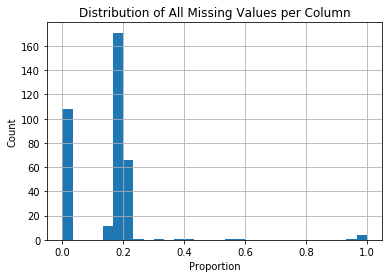

In [1173]:
# drop the missing data
# deal with columns
col_null=(mailout_train.isnull().sum()/len(mailout_train)).sort_values(ascending=False)
col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

In [1174]:
#remove the features that has over 30% missing rate
remove_mailout_train_features=col_null[col_null>0.3].index
print(remove_mailout_train_features)

Index(['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1',
       'KK_KUNDENTYP', 'KBA05_BAUMAX', 'AGER_TYP', 'EXTSEL992', 'ALTER_HH'],
      dtype='object')


In [1175]:
mailout_train.drop(labels=remove_mailout_train_features,axis=1,inplace=True)

In [1176]:
# deal with rows
row_null=(mailout_train.isnull().mean(axis=1)).sort_values(ascending=False)

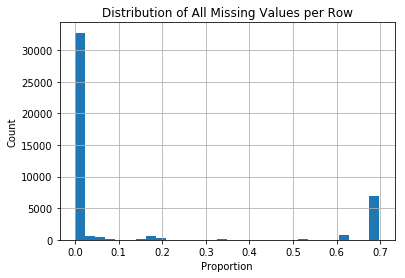

In [1177]:
row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

In [1178]:
remove_mailout_train_rows=row_null[row_null>0.5].index
print(remove_mailout_train_rows)

Int64Index([16717, 20423, 33956,  5740, 33951, 33949,  5742, 14369, 33938,
            33810,
            ...
             4647,  9552, 40621, 25979,   655, 37762,  6559,  6325, 27033,
            16214],
           dtype='int64', length=7868)


In [1179]:
mailout_train.drop(index=remove_mailout_train_rows,axis=0,inplace=True)

In [1180]:
mailout_train.shape

(35094, 357)

In [1181]:
mailout_train_attribute_value_number=[]
for i in mailout_train.columns:
    mailout_train_attribute_value_number.append((len(mailout_train[i].value_counts()),i))

In [1182]:
print(sorted(mailout_train_attribute_value_number))

[(2, 'ANREDE_KZ'), (2, 'DSL_FLAG'), (2, 'GREEN_AVANTGARDE'), (2, 'HH_DELTA_FLAG'), (2, 'KBA05_SEG6'), (2, 'KONSUMZELLE'), (2, 'OST_WEST_KZ'), (2, 'RESPONSE'), (2, 'SOHO_KZ'), (2, 'UNGLEICHENN_FLAG'), (2, 'VERS_TYP'), (3, 'ANZ_TITEL'), (3, 'D19_TELKO_ONLINE_QUOTE_12'), (3, 'HEALTH_TYP'), (3, 'KBA05_ANTG4'), (3, 'KBA05_KRSKLEIN'), (3, 'KBA05_KRSOBER'), (3, 'KBA05_KRSVAN'), (3, 'KBA05_KRSZUL'), (3, 'KBA05_MAXVORB'), (3, 'KBA13_ANTG4'), (3, 'KBA13_KMH_110'), (3, 'KBA13_KMH_251'), (3, 'KBA13_KW_30'), (3, 'NATIONALITAET_KZ'), (3, 'PLZ8_ANTG4'), (3, 'STRUKTURTYP'), (4, 'D19_VERSI_ONLINE_QUOTE_12'), (4, 'KBA05_ANHANG'), (4, 'KBA05_ANTG3'), (4, 'KBA05_MAXBJ'), (4, 'KBA05_MAXSEG'), (4, 'KBA05_MOD8'), (4, 'KBA05_MOTOR'), (4, 'KBA05_MOTRAD'), (4, 'KBA05_SEG1'), (4, 'KBA05_SEG7'), (4, 'KBA05_SEG8'), (4, 'KBA05_SEG9'), (4, 'KBA13_ANTG3'), (4, 'KBA13_KRSSEG_KLEIN'), (4, 'KBA13_KRSSEG_OBER'), (4, 'KBA13_KRSSEG_VAN'), (4, 'KBA13_KRSZUL_NEU'), (4, 'KBA13_MOTOR'), (4, 'KKK'), (4, 'PLZ8_ANTG3'), (4, 'SHOP

In [1183]:
mailout_train['MIN_GEBAEUDEJAHR']=2018-mailout_train['MIN_GEBAEUDEJAHR']
mailout_train['GEBURTSJAHR']=2018-mailout_train['GEBURTSJAHR']

In [1184]:
mailout_train.drop(labels=['EINGEZOGENAM_HH_JAHR', 'EINGEFUEGT_AM', 'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015'],axis=1,inplace=True)

In [1185]:
mailout_train.set_index('LNR',inplace=True)

In [1186]:
mailout_train.columns.to_series().groupby(mailout_train.dtypes).groups

{dtype('int64'): Index(['D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
        'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
        'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
        'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
        'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
        'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
        'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
        'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK',
        'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX',
        'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG',
        'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
        'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
        'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',
        'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST'

In [1187]:
mailout_train_binary_attribute=set([x[1] for x in mailout_train_attribute_value_number if x[0]==2])

In [1229]:
mailout_train_binary_attribute=mailout_train_binary_attribute-set(['RESPONSE'])

In [1189]:
mailout_train[list(mailout_train_binary_attribute)].head()

,ANREDE_KZ,OST_WEST_KZ,KBA05_SEG6,SOHO_KZ,DSL_FLAG,VERS_TYP,HH_DELTA_FLAG,RESPONSE,UNGLEICHENN_FLAG,GREEN_AVANTGARDE,KONSUMZELLE
LNR,,,,,,,,,,,
1763,2,W,0.0,0.0,1.0,2.0,0.0,0,0.0,0,1.0
1771,2,W,0.0,0.0,1.0,1.0,0.0,0,0.0,0,0.0
1776,1,O,0.0,0.0,1.0,1.0,NaN,0,0.0,1,0.0
1460,2,W,0.0,0.0,1.0,2.0,0.0,0,0.0,1,0.0
1783,1,W,0.0,0.0,1.0,1.0,0.0,0,0.0,0,0.0


In [1190]:
# # OST_WEST_KZ
mailout_train.loc[mailout_train['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
mailout_train.loc[mailout_train['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
mailout_train['ANREDE_KZ']=mailout_train['ANREDE_KZ']-1

In [1191]:
mailout_train[list(mailout_train_binary_attribute)].tail()

,ANREDE_KZ,OST_WEST_KZ,KBA05_SEG6,SOHO_KZ,DSL_FLAG,VERS_TYP,HH_DELTA_FLAG,RESPONSE,UNGLEICHENN_FLAG,GREEN_AVANTGARDE,KONSUMZELLE
LNR,,,,,,,,,,,
66338,0,1,0.0,0.0,1.0,1.0,1.0,0,0.0,1,0.0
67629,0,0,NaN,0.0,1.0,2.0,0.0,0,0.0,0,0.0
68273,0,1,0.0,0.0,1.0,1.0,0.0,0,0.0,0,0.0
68581,1,1,0.0,0.0,1.0,1.0,0.0,0,0.0,0,1.0
69224,1,1,0.0,0.0,1.0,1.0,0.0,0,0.0,0,0.0


In [1192]:
mailout_train[list(mailout_train_binary_attribute)]=mailout_train[list(mailout_train_binary_attribute)].astype('float')

In [1193]:
for l in mailout_train_binary_attribute:
    mailout_train[l].fillna(mailout_train[l].mode()[0], inplace=True)

In [1194]:
mailout_train['CAMEO_DEUG_2015'].value_counts()

6.0    3879
4.0    3677
8.0    3562
2.0    3325
3.0    3100
7.0    2196
5.0    1835
9.0    1744
1.0    1681
6      1476
4      1443
8      1438
2      1369
3      1317
7       861
9       708
1       696
5       687
X        11
Name: CAMEO_DEUG_2015, dtype: int64

In [1195]:
mailout_train['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

In [1196]:
mailout_train=mailout_train.astype('float')

In [1197]:
mailout_train.fillna(value=round(mailout_train.mean()),inplace=True)

In [1198]:
mailout_train_ordinal_list=list(set(mailout_train.columns)-mailout_train_binary_attribute-set(['RESPONSE']))

In [1199]:
mailout_train[mailout_train_ordinal_list]

,KBA13_CCM_1600,SEMIO_MAT,KBA05_HERSTTEMP,KBA13_KMH_140_210,KBA13_HALTER_45,STRUKTURTYP,KBA05_ZUL1,D19_REISEN,KBA13_KMH_110,KBA13_OPEL,KBA13_HALTER_20,KBA13_VORB_2,KBA13_GBZ,ALTERSKATEGORIE_GROB,D19_GESAMT_ONLINE_QUOTE_12,KBA05_VORB2,CJT_TYP_5,KBA13_KW_30,D19_VERSAND_ONLINE_DATUM,CJT_TYP_1,D19_BANKEN_ONLINE_QUOTE_12,KBA13_SEG_UTILITIES,KBA13_BJ_1999,KBA05_SEG1,KBA13_CCM_1000,KBA05_ANTG4,KBA05_HERST5,KBA05_CCM1,KBA13_ALTERHALTER_61,KBA13_CCM_3000,D19_SCHUHE,KBA05_ALTER3,KBA05_KRSVAN,KBA13_BJ_2000,WOHNLAGE,KBA05_KRSAQUOT,GFK_URLAUBERTYP,KBA13_BJ_2009,KBA13_KW_121,CJT_GESAMTTYP,KBA05_ANHANG,KBA05_MAXHERST,RELAT_AB,KBA05_KW3,KONSUMNAEHE,KBA13_SEG_MINIVANS,KBA13_BJ_2004,D19_GESAMT_ANZ_12,KBA05_SEG10,RT_UEBERGROESSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_HERST_AUDI_VW,VK_DHT4A,D19_BEKLEIDUNG_GEH,KBA13_RENAULT,ANZ_KINDER,KBA13_KW_50,KBA13_KW_120,KBA13_ANTG2,KBA05_ANTG1,KBA05_MOD3,KOMBIALTER,D19_FREIZEIT,KBA05_KRSHERST1,KBA13_SEG_GELAENDEWAGEN,KBA05_ZUL4,D19_VERSI_ONLINE_QUOTE_12,KBA05_SEG3,D19_KONSUMTYP_MAX,NATIONALITAET_KZ,KBA05_SEG5,KBA05_SEG7,UMFELD_ALT,KBA05_KRSZUL,PLZ8_HHZ,ANZ_TITEL,D19_LOTTO,KBA05_ZUL2,KBA13_SEG_SONSTIGE,SEMIO_KAEM,D19_WEIN_FEINKOST,KBA13_KMH_251,KBA13_MAZDA,KBA13_KRSHERST_BMW_BENZ,D19_VERSAND_DATUM,KBA13_NISSAN,MOBI_RASTER,KBA05_HERST1,KBA13_SITZE_6,EWDICHTE,GEBAEUDETYP,KBA05_MOD8,D19_VOLLSORTIMENT,D19_TELKO_ANZ_12,KBA13_VW,SEMIO_ERL,KBA13_CCM_2500,ALTERSKATEGORIE_FEIN,HH_EINKOMMEN_SCORE,ANZ_HAUSHALTE_AKTIV,KBA05_CCM4,KBA05_KRSHERST3,ZABEOTYP,D19_BEKLEIDUNG_REST,RT_SCHNAEPPCHEN,FINANZTYP,KBA13_KMH_210,D19_VERSICHERUNGEN,ANZ_STATISTISCHE_HAUSHALTE,D19_SONSTIGE,CJT_KATALOGNUTZER,SEMIO_REL,FINANZ_HAUSBAUER,KBA13_ALTERHALTER_30,D19_DIGIT_SERV,KBA13_HALTER_55,KBA13_SEG_MITTELKLASSE,ANZ_HH_TITEL,KBA05_GBZ,D19_GARTEN,PLZ8_ANTG4,D19_VERSAND_ANZ_24,PLZ8_ANTG1,KBA05_KRSHERST2,D19_HAUS_DEKO,FINANZ_UNAUFFAELLIGER,SEMIO_TRADV,KBA13_KMH_180,LP_STATUS_FEIN,KBA05_AUTOQUOT,BALLRAUM,KBA13_HALTER_40,KBA13_HALTER_50,KBA13_CCM_1500,D19_NAHRUNGSERGAENZUNG,KBA05_MOD4,KBA13_SITZE_4,CJT_TYP_4,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,KBA05_CCM2,AKT_DAT_KL,KBA05_MODTEMP,D19_GESAMT_DATUM,RT_KEIN_ANREIZ,D19_TELKO_ANZ_24,KBA13_CCM_2501,SEMIO_KRIT,KBA13_HALTER_60,D19_BIO_OEKO,D19_VERSAND_REST,KBA05_MOD1,CJT_TYP_2,WOHNDAUER_2008,D19_BANKEN_DATUM,D19_SOZIALES,KBA05_MAXAH,KBA13_KW_70,LP_LEBENSPHASE_FEIN,D19_GESAMT_OFFLINE_DATUM,VHN,KBA13_KW_0_60,VK_ZG11,KBA13_SEG_WOHNMOBILE,CJT_TYP_6,ARBEIT,KBA13_KRSHERST_AUDI_VW,D19_VERSI_OFFLINE_DATUM,KBA05_MAXVORB,KBA13_CCM_1400,KBA13_HERST_SONST,KBA05_HERST3,D19_TELKO_ONLINE_DATUM,PLZ8_ANTG3,KBA05_MOD2,D19_TELKO_MOBILE,D19_TELKO_REST,SEMIO_LUST,KBA13_FAB_SONSTIGE,D19_DROGERIEARTIKEL,KBA13_KMH_140,D19_LEBENSMITTEL,KBA13_KW_60,KKK,D19_BANKEN_GROSS,PLZ8_BAUMAX,D19_GESAMT_ONLINE_DATUM,SEMIO_VERT,SEMIO_FAM,D19_SAMMELARTIKEL,FIRMENDICHTE,KBA13_KRSSEG_KLEIN,D19_BUCH_CD,VHA,KBA13_SEG_KLEINST,KBA13_PEUGEOT,D19_BANKEN_REST,KBA13_BJ_2008,GEBAEUDETYP_RASTER,KBA13_SEG_OBERKLASSE,SHOPPER_TYP,PRAEGENDE_JUGENDJAHRE,D19_TELKO_OFFLINE_DATUM,D19_VERSI_ANZ_12,KBA13_KRSSEG_VAN,RETOURTYP_BK_S,KBA13_CCM_3001,KBA13_SITZE_5,KBA05_ALTER4,KBA05_VORB1,KBA13_HALTER_66,KBA13_KW_90,REGIOTYP,KBA05_ALTER2,D19_BANKEN_OFFLINE_DATUM,ORTSGR_KLS9,KBA05_KRSOBER,D19_BANKEN_LOKAL,D19_TELKO_ONLINE_QUOTE_12,SEMIO_SOZ,D19_TELKO_DATUM,ANZ_PERSONEN,SEMIO_KULT,INNENSTADT,UMFELD_JUNG,FINANZ_MINIMALIST,ONLINE_AFFINITAET,KBA05_SEG4,KBA05_ALTER1,KBA13_MERCEDES,KBA13_HERST_ASIEN,FINANZ_VORSORGER,MOBI_REGIO,KBA05_FRAU,D19_VERSAND_ONLINE_QUOTE_12,KBA13_ANTG3,KBA13_TOYOTA,KBA13_HALTER_65,KBA05_KW1,KBA13_HHZ,D19_BANKEN_ANZ_24,PLZ8_GBZ,KBA13_ALTERHALTER_45,KBA13_CCM_1200,KBA13_MOTOR,D19_BANKEN_ONLINE_DATUM,KBA05_SEG9,LP_FAMILIE_FEIN,D19_KOSMETIK,KBA05_DIESEL,KBA13_VORB_1,LP_LEBENSPHASE_GROB,VERDICHTUNGSRAUM,D19_RATGEBER,CJT_TYP_3,D19_BANKEN_ANZ_12,D19_ENERGIE,KBA13_CCM_1401_2500,D19_TECHNIK,KBA05_CCM3,GEBURTSJAHR,HEALTH_TYP,D19_KONSUMTYP,KBA13_FAB_ASIEN,KBA05_ANTG2,SEMIO_PFLICHT,KBA05_KW2,KBA13_KW_110,LP_STATUS_GROB,KBA13_ALTERHALTER_60,KBA13_CCM_2000,D19_VERSI_DATUM,KBA13

In [1200]:
scale = preprocessing.StandardScaler(copy=False)
mailout_train_scaled = scaler.fit_transform(mailout_train[mailout_train_ordinal_list]) 
mailout_train_ordinal_pd=pd.DataFrame(mailout_train_scaled, columns=mailout_train_ordinal_list,index=mailout_train.index)

In [1201]:
mailout_train.drop(labels=mailout_train_ordinal_list,axis=1,inplace=True)

In [1202]:
mailout_train=pd.concat([mailout_train, mailout_train_ordinal_pd], axis=1)

In [1203]:
mailout_train.shape

(35094, 351)

In [1204]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [1205]:
(mailout_train.isnull().sum()).sum()

0

In [1291]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.05, random_state=0)

In [1292]:
y_val.value_counts()

0.0    1733
1.0      22
Name: RESPONSE, dtype: int64

In [1460]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data
from torch.autograd import Variable
torch.set_default_dtype(torch.float64)

In [1461]:
torch_tensor_X_train = torch.tensor(X_train.values)
torch_tensor_y_train = torch.tensor(y_train.values,dtype=torch.long)
torch_tensor_X_val = torch.tensor(X_val.values)
torch_tensor_y_val = torch.tensor(y_val.values,dtype=torch.long)

In [1462]:
train_batch_size =30744
test_batch_size =30744

In [1463]:
train = torch.utils.data.TensorDataset(torch_tensor_X_train,torch_tensor_y_train)
test = torch.utils.data.TensorDataset(torch_tensor_X_val,torch_tensor_y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = train_batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = test_batch_size, shuffle = False)

In [1464]:
class Net(torch.nn.Module):  # simpleNet
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim): 
        super(Net, self).__init__()  
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1),nn.Dropout(0.5), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2),nn.Dropout(0.5), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
 
    def forward(self, x): 
#         x = F.relu(self.hidden(x)) 
#         x = self.out(x) 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [1465]:
model = Net(in_dim=350, n_hidden_1=120,n_hidden_2=10, out_dim=2)  # two classification has two n_features#实例化一个网络结构
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)  # 设置优化器参数,lr=0.002指的是学习率的大小
criterion = torch.nn.CrossEntropyLoss()  # 损失函数设置为loss_function

In [1466]:
epochs =1000
train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    for x1,y1 in train_loader:
        if torch.cuda.is_available():
            x1 = x1.cuda()
            y1 = y1.cuda()
        else:
            x1 = Variable(x1)
            y1= Variable(y1)
        out = model(x1)  # 100次迭代输出
        loss = loss_func(out, y1)  # 计算loss为out和y的差异
        optimizer.zero_grad()  # 清除一下上次梯度计算的数值
        loss.backward()  # 进行反向传播
        optimizer.step()  # 最优化迭代
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for x2,y2 in test_loader:
                if torch.cuda.is_available():
                    x2 = x2.cuda()
                    y2 = y2.cuda()
                else:
                    x2 = Variable(x2)
                    y2= Variable(y2)
                log_ps = model(x2)
                test_loss += criterion(log_ps,y2)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == y2.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

        prediction = torch.max(out, 1)[1].cpu()  ##返回每一行中最大值的那个元素，且返回其索引  torch.max()[1]， 只返回最大值的每个索引
        pred_y = prediction.data.numpy().squeeze()
        target_y = y_train_Variable.data.numpy()
        print(accuracy)

Epoch: 1/1000..  Training Loss: 0.972..  Test Loss: 0.904..  Test Accuracy: 0.013
tensor(0.0125, dtype=torch.float32)
Epoch: 2/1000..  Training Loss: 0.957..  Test Loss: 0.894..  Test Accuracy: 0.013
tensor(0.0125, dtype=torch.float32)
Epoch: 3/1000..  Training Loss: 0.950..  Test Loss: 0.884..  Test Accuracy: 0.013
tensor(0.0125, dtype=torch.float32)
Epoch: 4/1000..  Training Loss: 0.935..  Test Loss: 0.876..  Test Accuracy: 0.013
tensor(0.0125, dtype=torch.float32)
Epoch: 5/1000..  Training Loss: 0.926..  Test Loss: 0.868..  Test Accuracy: 0.013
tensor(0.0125, dtype=torch.float32)
Epoch: 6/1000..  Training Loss: 0.916..  Test Loss: 0.860..  Test Accuracy: 0.013
tensor(0.0125, dtype=torch.float32)
Epoch: 7/1000..  Training Loss: 0.905..  Test Loss: 0.852..  Test Accuracy: 0.013
tensor(0.0125, dtype=torch.float32)
Epoch: 8/1000..  Training Loss: 0.894..  Test Loss: 0.845..  Test Accuracy: 0.013
tensor(0.0125, dtype=torch.float32)
Epoch: 9/1000..  Training Loss: 0.884..  Test Loss: 0.83

Epoch: 70/1000..  Training Loss: 0.493..  Test Loss: 0.500..  Test Accuracy: 0.986
tensor(0.9863, dtype=torch.float32)
Epoch: 71/1000..  Training Loss: 0.490..  Test Loss: 0.496..  Test Accuracy: 0.986
tensor(0.9863, dtype=torch.float32)
Epoch: 72/1000..  Training Loss: 0.487..  Test Loss: 0.493..  Test Accuracy: 0.986
tensor(0.9863, dtype=torch.float32)
Epoch: 73/1000..  Training Loss: 0.484..  Test Loss: 0.489..  Test Accuracy: 0.986
tensor(0.9863, dtype=torch.float32)
Epoch: 74/1000..  Training Loss: 0.478..  Test Loss: 0.486..  Test Accuracy: 0.986
tensor(0.9863, dtype=torch.float32)
Epoch: 75/1000..  Training Loss: 0.476..  Test Loss: 0.482..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 76/1000..  Training Loss: 0.470..  Test Loss: 0.479..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 77/1000..  Training Loss: 0.467..  Test Loss: 0.476..  Test Accuracy: 0.987
tensor(0.9869, dtype=torch.float32)
Epoch: 78/1000..  Training Loss: 0.464..  Test L

Epoch: 139/1000..  Training Loss: 0.314..  Test Loss: 0.328..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 140/1000..  Training Loss: 0.312..  Test Loss: 0.326..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 141/1000..  Training Loss: 0.310..  Test Loss: 0.325..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 142/1000..  Training Loss: 0.308..  Test Loss: 0.323..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 143/1000..  Training Loss: 0.308..  Test Loss: 0.321..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 144/1000..  Training Loss: 0.307..  Test Loss: 0.320..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 145/1000..  Training Loss: 0.302..  Test Loss: 0.318..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 146/1000..  Training Loss: 0.302..  Test Loss: 0.317..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 147/1000..  Training Loss: 0.301.

Epoch: 208/1000..  Training Loss: 0.229..  Test Loss: 0.242..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 209/1000..  Training Loss: 0.229..  Test Loss: 0.241..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 210/1000..  Training Loss: 0.228..  Test Loss: 0.240..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 211/1000..  Training Loss: 0.226..  Test Loss: 0.240..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 212/1000..  Training Loss: 0.225..  Test Loss: 0.239..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 213/1000..  Training Loss: 0.225..  Test Loss: 0.238..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 214/1000..  Training Loss: 0.223..  Test Loss: 0.237..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 215/1000..  Training Loss: 0.223..  Test Loss: 0.236..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 216/1000..  Training Loss: 0.221.

Epoch: 277/1000..  Training Loss: 0.181..  Test Loss: 0.193..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 278/1000..  Training Loss: 0.181..  Test Loss: 0.192..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 279/1000..  Training Loss: 0.180..  Test Loss: 0.192..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 280/1000..  Training Loss: 0.181..  Test Loss: 0.191..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 281/1000..  Training Loss: 0.179..  Test Loss: 0.191..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 282/1000..  Training Loss: 0.180..  Test Loss: 0.190..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 283/1000..  Training Loss: 0.177..  Test Loss: 0.190..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 284/1000..  Training Loss: 0.179..  Test Loss: 0.189..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 285/1000..  Training Loss: 0.177.

Epoch: 346/1000..  Training Loss: 0.153..  Test Loss: 0.162..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 347/1000..  Training Loss: 0.151..  Test Loss: 0.162..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 348/1000..  Training Loss: 0.153..  Test Loss: 0.161..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 349/1000..  Training Loss: 0.152..  Test Loss: 0.161..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 350/1000..  Training Loss: 0.151..  Test Loss: 0.160..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 351/1000..  Training Loss: 0.151..  Test Loss: 0.160..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 352/1000..  Training Loss: 0.152..  Test Loss: 0.160..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 353/1000..  Training Loss: 0.151..  Test Loss: 0.159..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 354/1000..  Training Loss: 0.150.

Epoch: 415/1000..  Training Loss: 0.133..  Test Loss: 0.141..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 416/1000..  Training Loss: 0.133..  Test Loss: 0.141..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 417/1000..  Training Loss: 0.133..  Test Loss: 0.141..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 418/1000..  Training Loss: 0.132..  Test Loss: 0.140..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 419/1000..  Training Loss: 0.131..  Test Loss: 0.140..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 420/1000..  Training Loss: 0.131..  Test Loss: 0.140..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 421/1000..  Training Loss: 0.132..  Test Loss: 0.140..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 422/1000..  Training Loss: 0.132..  Test Loss: 0.139..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 423/1000..  Training Loss: 0.132.

Epoch: 484/1000..  Training Loss: 0.121..  Test Loss: 0.126..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 485/1000..  Training Loss: 0.120..  Test Loss: 0.126..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 486/1000..  Training Loss: 0.121..  Test Loss: 0.126..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 487/1000..  Training Loss: 0.120..  Test Loss: 0.126..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 488/1000..  Training Loss: 0.119..  Test Loss: 0.126..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 489/1000..  Training Loss: 0.119..  Test Loss: 0.126..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 490/1000..  Training Loss: 0.118..  Test Loss: 0.125..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 491/1000..  Training Loss: 0.118..  Test Loss: 0.125..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 492/1000..  Training Loss: 0.118.

Epoch: 553/1000..  Training Loss: 0.108..  Test Loss: 0.115..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 554/1000..  Training Loss: 0.109..  Test Loss: 0.115..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 555/1000..  Training Loss: 0.110..  Test Loss: 0.115..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 556/1000..  Training Loss: 0.110..  Test Loss: 0.115..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 557/1000..  Training Loss: 0.109..  Test Loss: 0.115..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 558/1000..  Training Loss: 0.109..  Test Loss: 0.115..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 559/1000..  Training Loss: 0.108..  Test Loss: 0.114..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 560/1000..  Training Loss: 0.110..  Test Loss: 0.114..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 561/1000..  Training Loss: 0.108.

Epoch: 622/1000..  Training Loss: 0.102..  Test Loss: 0.107..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 623/1000..  Training Loss: 0.102..  Test Loss: 0.107..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 624/1000..  Training Loss: 0.101..  Test Loss: 0.107..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 625/1000..  Training Loss: 0.103..  Test Loss: 0.107..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 626/1000..  Training Loss: 0.102..  Test Loss: 0.107..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 627/1000..  Training Loss: 0.102..  Test Loss: 0.107..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 628/1000..  Training Loss: 0.101..  Test Loss: 0.106..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 629/1000..  Training Loss: 0.101..  Test Loss: 0.106..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 630/1000..  Training Loss: 0.101.

Epoch: 691/1000..  Training Loss: 0.096..  Test Loss: 0.101..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 692/1000..  Training Loss: 0.096..  Test Loss: 0.101..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 693/1000..  Training Loss: 0.097..  Test Loss: 0.101..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 694/1000..  Training Loss: 0.096..  Test Loss: 0.100..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 695/1000..  Training Loss: 0.096..  Test Loss: 0.100..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 696/1000..  Training Loss: 0.096..  Test Loss: 0.100..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 697/1000..  Training Loss: 0.098..  Test Loss: 0.100..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 698/1000..  Training Loss: 0.097..  Test Loss: 0.100..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 699/1000..  Training Loss: 0.096.

Epoch: 760/1000..  Training Loss: 0.091..  Test Loss: 0.096..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 761/1000..  Training Loss: 0.091..  Test Loss: 0.096..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 762/1000..  Training Loss: 0.092..  Test Loss: 0.095..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 763/1000..  Training Loss: 0.093..  Test Loss: 0.095..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 764/1000..  Training Loss: 0.091..  Test Loss: 0.095..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 765/1000..  Training Loss: 0.092..  Test Loss: 0.095..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 766/1000..  Training Loss: 0.090..  Test Loss: 0.095..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 767/1000..  Training Loss: 0.093..  Test Loss: 0.095..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 768/1000..  Training Loss: 0.091.

Epoch: 829/1000..  Training Loss: 0.087..  Test Loss: 0.091..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 830/1000..  Training Loss: 0.087..  Test Loss: 0.091..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 831/1000..  Training Loss: 0.088..  Test Loss: 0.091..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 832/1000..  Training Loss: 0.087..  Test Loss: 0.091..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 833/1000..  Training Loss: 0.089..  Test Loss: 0.091..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 834/1000..  Training Loss: 0.088..  Test Loss: 0.091..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 835/1000..  Training Loss: 0.088..  Test Loss: 0.091..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 836/1000..  Training Loss: 0.088..  Test Loss: 0.091..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 837/1000..  Training Loss: 0.087.

Epoch: 898/1000..  Training Loss: 0.085..  Test Loss: 0.088..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 899/1000..  Training Loss: 0.084..  Test Loss: 0.088..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 900/1000..  Training Loss: 0.085..  Test Loss: 0.088..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 901/1000..  Training Loss: 0.085..  Test Loss: 0.088..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 902/1000..  Training Loss: 0.085..  Test Loss: 0.088..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 903/1000..  Training Loss: 0.085..  Test Loss: 0.088..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 904/1000..  Training Loss: 0.084..  Test Loss: 0.088..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 905/1000..  Training Loss: 0.085..  Test Loss: 0.088..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 906/1000..  Training Loss: 0.086.

Epoch: 967/1000..  Training Loss: 0.083..  Test Loss: 0.085..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 968/1000..  Training Loss: 0.082..  Test Loss: 0.085..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 969/1000..  Training Loss: 0.083..  Test Loss: 0.085..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 970/1000..  Training Loss: 0.081..  Test Loss: 0.085..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 971/1000..  Training Loss: 0.082..  Test Loss: 0.085..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 972/1000..  Training Loss: 0.082..  Test Loss: 0.085..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 973/1000..  Training Loss: 0.081..  Test Loss: 0.085..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 974/1000..  Training Loss: 0.083..  Test Loss: 0.085..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 975/1000..  Training Loss: 0.082.

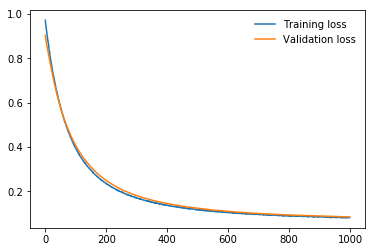

In [1467]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [1374]:
mailout_test = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

c:\program files\python3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1375]:
mailout_test.set_index('LNR',inplace=True)

In [1376]:
mailout_test=unknown2missing(mailout_test)
mailout_test['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

In [1377]:
print(mailout_test.isnull().mean().mean())

0.14858425954383528


In [1378]:
# dorp the features with mailout_train
mailout_test.drop(labels=list(set(mailout_test.columns)-set(mailout_train.columns)),axis=1,inplace=True)

In [1379]:
print(mailout_test.isnull().mean().mean())

0.13205112213213444


In [1380]:
mailout_test.shape

(42833, 350)

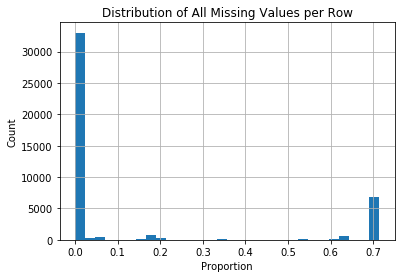

In [1381]:
test_row_null=(mailout_test.isnull().mean(axis=1)).sort_values(ascending=False)
test_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');


In [1382]:
remove_mailout_test_rows=test_row_null[test_row_null>0.5].index
len(remove_mailout_test_rows)

7734

In [1383]:
mailout_test['MIN_GEBAEUDEJAHR']=2018-mailout_test['MIN_GEBAEUDEJAHR']
mailout_test['GEBURTSJAHR']=2018-mailout_test['GEBURTSJAHR']

In [1384]:
# # OST_WEST_KZ
mailout_test.loc[mailout_test['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
mailout_test.loc[mailout_test['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
mailout_test['ANREDE_KZ']=mailout_test['ANREDE_KZ']-1

In [1385]:
for l in mailout_train_binary_attribute:
    mailout_test[l].fillna(mailout_test[l].mode()[0], inplace=True)

In [1386]:
mailout_test=mailout_test.astype('float')

In [1387]:
mailout_test.fillna(value=round(mailout_test.mean()),inplace=True)

In [1388]:
mailout_test.isnull().sum().sum()

0

In [1389]:
scale = preprocessing.StandardScaler(copy=False)
mailout_test_scaled = scaler.fit_transform(mailout_test[mailout_train_ordinal_list]) 
mailout_test_ordinal_pd=pd.DataFrame(mailout_test_scaled, columns=mailout_train_ordinal_list,index=mailout_test.index)

In [1390]:
mailout_test.drop(labels=mailout_train_ordinal_list,axis=1,inplace=True)

mailout_test=pd.concat([mailout_test, mailout_test_ordinal_pd], axis=1)

In [1391]:
mailout_test.isnull().sum().sum()

0

In [1392]:
mailout_test.shape

(42833, 350)

In [1469]:
# ready for predict
test_dataset = torch.tensor(mailout_test.values)
new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 42833, shuffle = False)

In [1470]:
results = []
with torch.no_grad():
    model.eval()
    for t in new_test_loader:
        if torch.cuda.is_available():
            t = t.cuda()
        output = model(t)
        output=output.cpu()
        sm = torch.nn.Softmax()
        probabilities = sm(output) 
        print(probabilities.numpy()[:,1]) 
        results=probabilities.numpy()[:,1]
        #Converted to probabilities
#         ps = torch.exp(output)
#         top_p, top_class = ps.topk(1, dim = 1)
#         results += top_class.numpy().tolist()

[0.03351155 0.03591102 0.03956187 ... 0.03634206 0.04411164 0.05496436]


c:\program files\python3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [1471]:
submissions=pd.DataFrame({"LNR": mailout_test.index,
                         "RESPONSE": results})
submissions.to_csv("my_submissions.csv", index=False, header=True)

In [1472]:
submissions['RESPONSE'].value_counts()

0.040415    1991
0.040699    1226
0.040077     891
0.040784     768
0.040181     459
0.040312     303
0.043355       2
0.053060       1
0.027249       1
0.020878       1
0.049146       1
0.046209       1
0.052901       1
0.043623       1
0.034065       1
0.036053       1
0.052504       1
0.052162       1
0.043433       1
0.045348       1
0.078819       1
0.043747       1
0.045966       1
0.055921       1
0.058656       1
0.035379       1
0.061276       1
0.022239       1
0.049851       1
0.036930       1
            ... 
0.031680       1
0.042253       1
0.033677       1
0.037730       1
0.032393       1
0.033938       1
0.040136       1
0.064455       1
0.046047       1
0.039008       1
0.028237       1
0.050168       1
0.041468       1
0.039349       1
0.049931       1
0.035185       1
0.029629       1
0.040730       1
0.060292       1
0.033852       1
0.033820       1
0.041489       1
0.025730       1
0.047586       1
0.051193       1
0.035590       1
0.064118       1
0.043348      